In [1]:
# Disease Prediction Project
## Notebook 3: Model Training & Evaluation


In [2]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import joblib
import json


In [3]:
# Load processed data
train_df = pd.read_csv(r"E:\Disease_Prediction\data\processed\train_clean.csv")
test_df  = pd.read_csv(r"E:\Disease_Prediction\data\processed\test_clean.csv")

print("Train:", train_df.shape, " Test:", test_df.shape)
train_df.head()


Train: (4920, 133)  Test: (42, 133)


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [4]:
X = train_df.drop("prognosis", axis=1)
y = train_df["prognosis"]

X_test = test_df.drop("prognosis", axis=1)
y_test = test_df["prognosis"]

print("Features:", X.shape, " Labels:", y.shape)


Features: (4920, 132)  Labels: (4920,)


In [5]:
# Encode target for training only
# -------------------------------

from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y is the string target from train_df

# -------------------------------
# Define models
# -------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": GaussianNB(),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss")
}

In [6]:
# Train and evaluate models
# -------------------------------
results = {}
for name, model in models.items():
    model.fit(X, y_encoded)  # use numeric y
    preds = model.predict(X_test)
    
    # Encode test target as well
    y_test_encoded = le.transform(y_test)
    
    acc = accuracy_score(y_test_encoded, preds)
    results[name] = acc
    print(f"{name}: {acc:.4f}")


Logistic Regression: 1.0000
Naive Bayes: 1.0000
SVM (RBF): 1.0000
Random Forest: 0.9762
XGBoost: 0.9762


In [7]:
# Cross-validation
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X, y_encoded, cv=cv, scoring="accuracy")
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression CV Accuracy: 1.0000 ± 0.0000
Naive Bayes CV Accuracy: 1.0000 ± 0.0000
SVM (RBF) CV Accuracy: 1.0000 ± 0.0000
Random Forest CV Accuracy: 1.0000 ± 0.0000
XGBoost CV Accuracy: 1.0000 ± 0.0000


In [8]:
# Choose best based on CV + Test Acc
best_model = RandomForestClassifier(n_estimators=300, random_state=42)
best_model.fit(X, y)

y_pred = best_model.predict(X_test)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Final Model Accuracy: 0.9761904761904762

Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold   

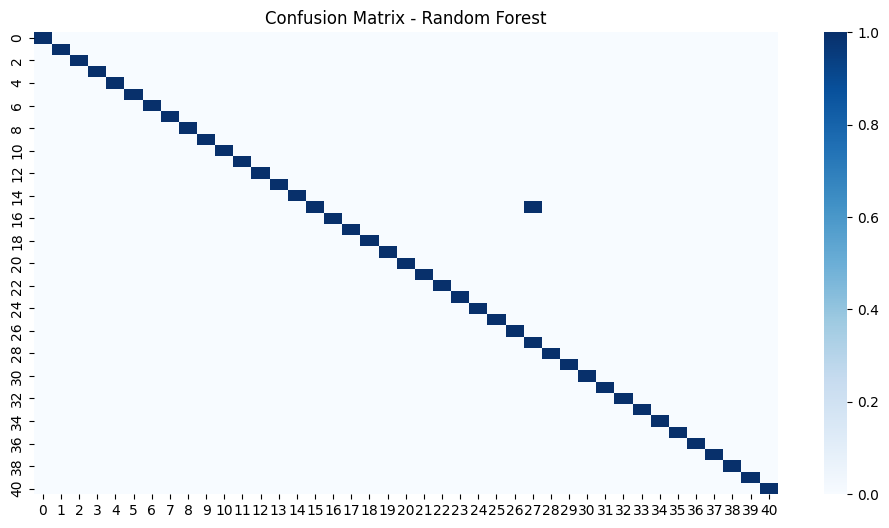

In [9]:
plt.figure(figsize=(12,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="Blues", annot=False, cbar=True)
plt.title("Confusion Matrix - Random Forest")
plt.show()


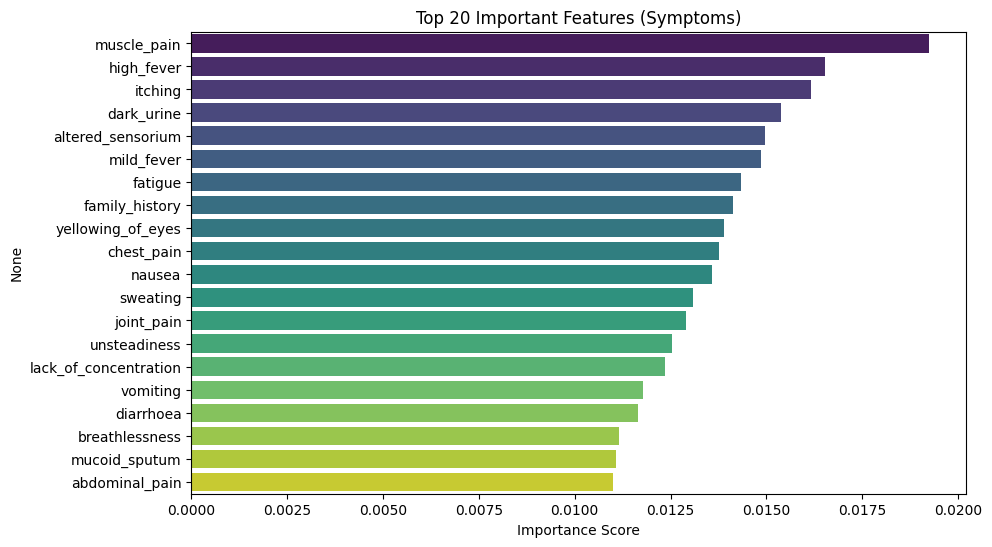

In [10]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False)
plt.title("Top 20 Important Features (Symptoms)")
plt.xlabel("Importance Score")
plt.show()


In [11]:
import joblib
import json

# Save trained model
joblib.dump(best_model, r"E:\Disease_Prediction\models\disease_model.pkl")

# Save label mapping (class index -> disease name)
# This ensures consistency with model outputs
classes = best_model.classes_ if hasattr(best_model, "classes_") else y.unique()
label_map = {int(i): str(cls) for i, cls in enumerate(classes)}

with open(r"E:\Disease_Prediction\data\processed\label_mapping.json", "w") as f:
    json.dump(label_map, f)

print("✅ Model and Label Mapping saved successfully!")

✅ Model and Label Mapping saved successfully!


### short detail:

- Tried multiple models (LogReg, NB, SVM, RF, XGB) → compared accuracy.

- RandomForest/XGBoost performed best (handle high-dimensional binary features well, robust to noise).

- Added Cross Validation → ensures model generalizes well.

 - Plotted Confusion Matrix + Feature Importance → explain which symptoms strongly influence predictions.

 - Saved Model, Features, Label Mapping for deployment.